In [1]:
import pandas as pd
import re
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer
)
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

(Much of this code borrowed from Andrew, as it's cleaner and faster, thanks Andrew!)  
##### Load and prepare data:

In [3]:
faults_raw = pd.read_csv("../data/J1939Faults.csv", dtype={"EquipmentID": str, 'spn':int})
diagnostics_raw = pd.read_csv("../data/vehiclediagnosticonboarddata.csv")

In [4]:
faults_raw['EventTimeStamp'] = pd.to_datetime(faults_raw['EventTimeStamp'])

In [5]:
# prepare faults
faults_drop_cols = ["actionDescription", "activeTransitionCount", "ecuSource", "ecuSoftwareVersion", "ecuModel", "ecuMake", "faultValue", "MCTNumber", "LocationTimeStamp"]
faults = faults_raw.drop(columns=faults_drop_cols)

In [6]:
# join diagnostics
diagnostics_raw["Value"] = diagnostics_raw["Value"].replace(
    {"FALSE": False, "TRUE": True}
)

# pivot diagnostics to long format
diagnostics = diagnostics_raw.pivot(
    index="FaultId", columns="Name", values="Value"
)

joined = faults.merge(diagnostics, how = "inner", left_on='RecordID', right_on='FaultId')

(Borrowing from Jeff)
##### Adding some feature engineering for severity level

In [8]:
def extract_severity(text):

    if pd.isna(text):
        return np.nan
        
    # "Severity" followed by "Low", "Medium", or "High"
    pattern = r'Severity\s+(Low|Medium|High)'
    
    # Search for the pattern 
    match = re.search(pattern, text)
    
    if match:
        # Return "Severity" plus the matched level
        return f"Severity {match.group(1)}"
    else:
        return np.nan

# Apply the function to create the new column
joined['SeverityLevel'] = joined['eventDescription'].apply(extract_severity)

In [9]:
severity_map = {
    'Severity Low': 1,
    'Severity Medium': 2,
    'Severity High': 3
}

joined['SeverityLevelFeature'] = joined['SeverityLevel'].map(severity_map)

joined.loc[joined['spn'] == 1569, 'SeverityLevelFeature'] = 4
joined.loc[joined['spn'] == 5394, 'SeverityLevelFeature'] = 4
joined.loc[joined['spn'] == 4094, 'SeverityLevelFeature'] = 4
joined.loc[joined['spn'] == 5246, 'SeverityLevelFeature'] = 5

##### Filter out faults near service stations:

In [11]:
# filter out near service stations
joined_pre_station_filter = joined
stations = pd.DataFrame(
    {
        "lat": [36.0666667, 35.5883333, 36.1950],
        "lon": [-86.4347222, -86.4438888, -83.174722],
    }
)
threshold_miles = 0.5
threshold_meters = threshold_miles * 1609.34
# create geodataframes with geopandas
gdf_joined = gpd.GeoDataFrame(
    joined,
    geometry=gpd.points_from_xy(joined.Latitude, joined.Longitude),
    crs="EPSG:4326",  # WGS84 coord ref sys (lat/lon)
)
gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations.lat, stations.lon),
    crs="EPSG:4326",
)
target_crs = "EPSG:9311"
# reproject onto new crs for better distance measurement
gdf_joined_proj = gdf_joined.to_crs(target_crs)
gdf_stations_proj = gdf_stations.to_crs(target_crs)
# create buffers around stations
station_buf = gdf_stations_proj.geometry.buffer(threshold_meters)
combined_buffer = (
    station_buf.union_all()
)  # turns into single geometry which helps with efficiency
is_within = gdf_joined_proj.geometry.within(combined_buffer)
joined["nearStation"] = is_within.values
joined_post_filter = joined[~joined["nearStation"]]

In [12]:
joined_ns = joined[joined['nearStation'] == False]

##### Cleaning up dataframe, and converting data to usable types:

In [14]:
joined_ns = joined_ns.drop(columns = ['ESS_Id'
                                      , 'ecuSerialNumber'
                                      , 'AcceleratorPedal'
                                      , 'CruiseControlActive'
                                      , 'CruiseControlSetSpeed'
                                      , 'Latitude'
                                      , 'Longitude'
                                      , 'IgnStatus'
                                      , 'ParkingBrake'
                                      , 'LampStatus'
                                      , 'ServiceDistance'
                                      , 'nearStation'
                                      , 'eventDescription'
                                      , 'SeverityLevel'])

In [15]:
cols = ['BarometricPressure', 'DistanceLtd',
       'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure',
       'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel',
       'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature', 
        'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure']

joined_ns[cols] = joined_ns[cols].apply(pd.to_numeric, errors='coerce', axis=1)

(Again borrowing this bit from Andrew)  
##### Adding in a derate window which includes a 5246 derate event and any event within a 2-hr window preceding

In [17]:
col_order = [
    "RecordID",
    "EquipmentID",
    "EventTimeStamp",
    "spn",
    "fmi",
    "SeverityLevelFeature",
    "active",
    "BarometricPressure",
    "DistanceLtd",
    "EngineCoolantTemperature",
    "EngineLoad",
    "EngineOilPressure",
    "EngineOilTemperature",
    "EngineRpm",
    "EngineTimeLtd",
    "FuelLevel",
    "FuelLtd",
    "FuelRate",
    "FuelTemperature",
    "IntakeManifoldTemperature",
    "Speed",
    "SwitchedBatteryVoltage",
    "Throttle",
    "TurboBoostPressure"
]
target_spn = 5246

# --- SORTING STEP ---
# Sort by EquipmentID and then chronologically by EventTimeStamp
joined_ns = joined_ns.sort_values(by=["EquipmentID", "EventTimeStamp"]).copy()

# Create a Series containing only the timestamps of trigger events
trigger_timestamps_only = joined_ns["EventTimeStamp"].where(joined_ns["spn"] == target_spn)

# For each row, find the timestamp of the *next* trigger event within its group
# Group by EquipmentID and use backward fill (bfill)
# This fills NaT values with the next valid timestamp in the group
joined_ns["next_trigger_time"] = trigger_timestamps_only.groupby(
    joined_ns["EquipmentID"]
).bfill()

# Calculate the start of the 2-hour window before the next trigger
joined_ns["window_start_time"] = joined_ns["next_trigger_time"] - pd.Timedelta(hours=5)

# Label rows as True if their timestamp falls within the window:
#    [window_start_time, next_trigger_time]
#    Also ensure that a next_trigger_time actually exists (it's not NaT)
joined_ns["derate_window"] = (
    (joined_ns["EventTimeStamp"] >= joined_ns["window_start_time"])
    & (joined_ns["EventTimeStamp"] <= joined_ns["next_trigger_time"])
    & (joined_ns["next_trigger_time"].notna())
)

# Drop helper columns if no longer needed
joined_ns = joined_ns.drop(columns=['next_trigger_time', 'window_start_time'])

##### Filtering out any active = False events (as they mark the end of an event, rather than a fault coming on):

In [19]:
joined_ns_act = joined_ns[joined_ns['active'] == True]
joined_ns_act = joined_ns_act.drop(columns = ['active'])

##### Turning the derate window from a boolean to numeric:

In [21]:
joined_ns_act['derate'] = np.where(joined_ns_act['derate_window'] == True, 1, 0)

##### Separating training and test data by date:

In [23]:
joined_ns_act['IsTestData'] = joined_ns_act['EventTimeStamp'] >= '2019-01-01'
train_data = joined_ns_act[joined_ns_act['IsTestData'] == False]
test_data = joined_ns_act[joined_ns_act['IsTestData'] == True]

In [24]:
random_state = 321

X_train = train_data.drop(columns = ['RecordID'
                                     , 'EventTimeStamp'
                                     , 'EquipmentID'
                                     , 'derate_window'
                                     , 'derate'
                                     , 'IsTestData'])
y_train = train_data['derate']

X_test = test_data.drop(columns = ['RecordID'
                                   , 'EventTimeStamp'
                                   , 'EquipmentID'
                                   , 'derate_window'
                                   , 'derate'
                                   , 'IsTestData'])
y_test = test_data['derate']

##### Imputing missing values:

In [26]:
si = SimpleImputer().fit(X_train)

X_train = si.transform(X_train)
X_test = si.transform(X_test)

##### Model time:

Accuracy: 0.8506
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92     56410
           1       0.02      0.78      0.04       201

    accuracy                           0.85     56611
   macro avg       0.51      0.81      0.48     56611
weighted avg       1.00      0.85      0.92     56611



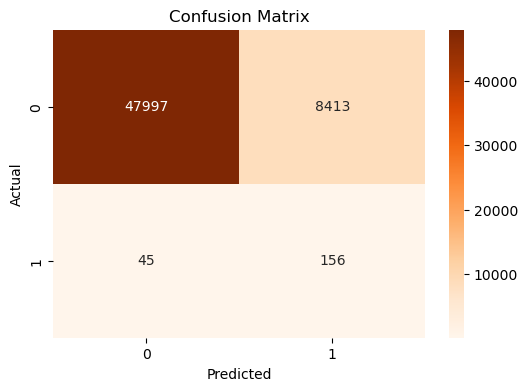

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)

#removed, as PCA makes results worse
#pca = PCA(n_components = 3)
#X_train_scaled = pca.fit_transform(X_train_scaled)
#X_test_scaled = pca.transform(X_test_scaled)

lr_model = LogisticRegression(class_weight='balanced', random_state=random_state)
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=lr_model.classes_,
            yticklabels=lr_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##### Analysis time:

In [30]:
analysis = test_data.copy()
analysis['prediction'] = y_pred
analysis['probability'] = lr_model.predict_proba(X_test_scaled)[:,1] #grab predicted probability of all derates

For later comparison, creating a dataframe of derates after 2019 (after eliminating 'duplicate' derates):

In [32]:
derates_2019 = joined_ns[(joined_ns['spn'] == 5246) & (joined_ns['EventTimeStamp'] > '12-31-2018') & (joined_ns['active'] == True)].copy()
derates_2019['derate_gap'] = derates_2019.sort_values(by=['EquipmentID', 'EventTimeStamp']).groupby('EquipmentID')['EventTimeStamp'].diff()
gap = pd.to_timedelta("24 hours")
confirmed_derates_2019 = derates_2019[(derates_2019.derate_gap.isnull()) | (derates_2019['derate_gap'] > gap)]

Repurposing Andrew's earlier code to find gaps between derate and prediction, eliminate 'duplicate' positives (those predicting same event) and anything within the derate window:

In [34]:
tp_analysis_temp = analysis[(analysis['derate'] == 1.0) & (analysis['prediction'] == 1.0)]
tp_analysis_temp = tp_analysis_temp[['EventTimeStamp', 'spn', 'EquipmentID', 'derate_window', 'derate', 'prediction', 'probability']]

target_spn = 5246

tp_analysis_temp = tp_analysis_temp.sort_values(by=["EquipmentID", "EventTimeStamp"]).copy()

trigger_timestamps_only = tp_analysis_temp["EventTimeStamp"].where(tp_analysis_temp["spn"] == target_spn)

tp_analysis_temp["next_trigger_time"] = trigger_timestamps_only.groupby(
    tp_analysis_temp["EquipmentID"]
).bfill()

In [35]:
tp_analysis = tp_analysis_temp.copy()
tp_analysis['trigger_gap'] = tp_analysis['next_trigger_time'] - tp_analysis['EventTimeStamp']
trigger_gap = pd.to_timedelta("2 hours")
tp_analysis = tp_analysis[(tp_analysis['trigger_gap'] > trigger_gap)]
tp_analysis.drop_duplicates(subset=['next_trigger_time'], keep = 'first', inplace = True)
tp_analysis = tp_analysis[(tp_analysis['spn'] != 5246) & (tp_analysis.next_trigger_time.notnull())]
tp_analysis['derate_gap'] = tp_analysis.sort_values(by=['EquipmentID', 'EventTimeStamp']).groupby('EquipmentID')['EventTimeStamp'].diff()
gap = pd.to_timedelta("24 hours")
true_positives = tp_analysis[(tp_analysis.derate_gap.isnull()) | (tp_analysis['derate_gap'] > gap)]
true_positives

,EventTimeStamp,spn,EquipmentID,derate_window,derate,prediction,probability,next_trigger_time,trigger_gap,derate_gap
1079301,2019-02-20 15:09:45,1569,1739,True,1,1,0.952313,2019-02-20 19:21:49,0 days 04:12:04,NaT
1069365,2019-01-29 19:47:34,1569,1758,True,1,1,0.953517,2019-01-29 22:35:39,0 days 02:48:05,NaT
1070446,2019-01-31 18:56:41,1569,1758,True,1,1,0.934820,2019-01-31 21:23:21,0 days 02:26:40,1 days 23:09:07
1072210,2019-02-05 16:29:05,1569,1758,True,1,1,0.948353,2019-02-05 19:59:02,0 days 03:29:57,4 days 16:55:53
1127497,2019-07-14 02:13:19,1569,1818,True,1,1,0.870145,2019-07-14 05:02:48,0 days 02:49:29,NaT
1127794,2019-07-15 07:09:53,1569,1818,True,1,1,0.943704,2019-07-15 11:17:38,0 days 04:07:45,1 days 04:56:34
1135713,2019-08-15 16:26:05,1569,1818,True,1,1,0.968871,2019-08-15 19:20:56,0 days 02:54:51,31 days 09:16:12
1065881,2019-01-21 04:38:44,1569,1827,True,1,1,0.963553,2019-01-21 09:01:38,0 days 04:22:54,NaT
1099297,2019-04-11 13:48:02,1569,1834,True,1,1,0.928116,2019-04-11 18:05:51,0 days 04:17:49,NaT
1067823,2019-01-25 10:15:43,1569,1857,True,1,1,0.984806,2019-01-25 13:27:36,0 days 03:11:53,NaT


##### Culling repeat false positives (those predicting same event):

In [37]:
fp_analysis = analysis[(analysis['derate'] == 0.0) & (analysis['prediction'] == 1.0)]
fp_analysis = fp_analysis[['EventTimeStamp', 'spn', 'EquipmentID', 'derate_window', 'derate', 'prediction', 'probability']]
fp_analysis['derate_gap'] = fp_analysis.sort_values(by=['EquipmentID', 'EventTimeStamp']).groupby('EquipmentID')['EventTimeStamp'].diff()
gap = pd.to_timedelta("24 hours")
false_positives = fp_analysis[(fp_analysis.derate_gap.isnull()) | (fp_analysis['derate_gap'] > gap)]
false_positives

,EventTimeStamp,spn,EquipmentID,derate_window,derate,prediction,probability,derate_gap
1064171,2019-01-16 19:41:28,37,105338729,False,0,1,0.739838,NaT
1086711,2019-03-07 16:48:19,1675,105338729,False,0,1,0.664269,49 days 21:06:51
1093996,2019-03-27 08:10:52,111,105338729,False,0,1,0.786659,19 days 14:27:44
1094665,2019-03-29 06:08:56,111,105338729,False,0,1,0.728640,1 days 21:24:35
1101144,2019-04-16 12:27:33,111,105338729,False,0,1,0.540059,18 days 06:18:37
...,...,...,...,...,...,...,...,...
1106714,2019-05-03 15:34:52,829,309,False,0,1,0.667837,16 days 03:13:30
1119956,2019-06-14 12:28:50,829,309,False,0,1,0.641377,41 days 20:53:58
1130391,2019-07-24 12:09:01,829,309,False,0,1,0.635276,39 days 23:40:11
1131863,2019-07-31 12:19:46,829,309,False,0,1,0.629519,7 days 00:10:45


##### Now to watch the money pour in:

In [39]:
true_positives.shape[0] * 4000 - false_positives.shape[0] * 500

-1874500

...oh...